In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
import warnings

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import dill

sys.path.append('..')
from seismiqb.batchflow import Dataset, Pipeline, B, V, C, L, F, D, DatasetIndex
from seismiqb.batchflow.models.tf import UNet, TFModel
from seismiqb import SeismicCropBatch, Geometry, parse_labels, make_histosampler
from seismiqb import make_geometries, make_labels, make_samplers
from seismiqb import repair


from tqdm import tqdm_notebook
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
path_data = '../../data/Facies/VU_ONGMK/3003_ES360_Ref_Stk_Ang_10_35_Depth.sgy'

In [4]:
geom = Geometry(path_data, verbose=True)


File header:  {JobID: 0, LineNumber: 0, ReelNumber: 0, Traces: 0, AuxTraces: 0, Interval: 4000, IntervalOriginal: 0, Samples: 1071, SamplesOriginal: 0, Format: 1, EnsembleFold: 0, SortingCode: 0, VerticalSum: 0, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, Sweep: 0, SweepChannel: 0, SweepTaperStart: 0, SweepTaperEnd: 0, Taper: 0, CorrelatedTraces: 0, BinaryGainRecovery: 0, AmplitudeRecovery: 0, MeasurementSystem: 1, ImpulseSignalPolarity: 0, VibratoryPolarity: 0, SEGYRevision: 0, TraceFlag: 1, ExtendedHeaders: 0}


Trace header:  {TRACE_SEQUENCE_LINE: 1, TRACE_SEQUENCE_FILE: 0, FieldRecord: 0, TraceNumber: 0, EnergySourcePoint: 0, CDP: 0, CDP_TRACE: 1, TraceIdentificationCode: 1, NSummedTraces: 0, NStackedTraces: 0, DataUse: 0, offset: 0, ReceiverGroupElevation: 0, SourceSurfaceElevation: 0, SourceDepth: 0, ReceiverDatumElevation: 0, SourceDatumElevation: 0, SourceWaterDepth: 0, GroupWaterDepth: 0, ElevationScalar: 0, SourceGroupScalar: 1, SourceX: 0, SourceY: 0, Grou


Number of duplicates: 0
Number of points missing:  1472


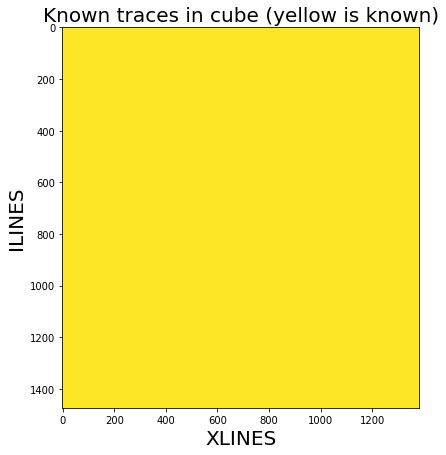

In [5]:
# Check some stats and draw cube from above
dupl, dupl_count = {}, 0
for k, v in tqdm_notebook(geom.il_xl_trace.items()):
    if dupl.get(k) is not None:
        dupl[k] += 1
        dupl_count += 1
    else:
        dupl[k] =1
    
print('Number of duplicates:', dupl_count)

possible_coordinates = [(i, x) for i in geom.ilines for x in geom.xlines]
missing_points = list(set(possible_coordinates) - set(geom.il_xl_trace.keys()))    
print('Number of points missing: ', len(missing_points))


m = np.zeros((geom.ilines_len, geom.xlines_len))
for point in tqdm_notebook(possible_coordinates):
    if point in geom.il_xl_trace.keys():
        m[point[0] - geom.ilines_offset, point[1] - geom.xlines_offset] += 1
        

fig, ax = plt.subplots(figsize=(12, 7))
ax.imshow(m)
ax.set_title('Known traces in cube (yellow is known)', fontdict={'fontsize': 20})
plt.xlabel('XLINES', fontdict={'fontsize': 20})
plt.ylabel('ILINES', fontdict={'fontsize': 20})
plt.show()

In [6]:
path_labels_txt = ['../../data/Facies/VU_ONGMK/H_Kn_Kn2/H_Kn.txt',
                   '../../data/Facies/VU_ONGMK/H_Kn_Kn2/H_Kn2.txt',
                   '../../data/Facies/VU_ONGMK/H_P1art_P6/H_P1art.txt',
                   '../../data/Facies/VU_ONGMK/H_P1art_P6/H_P6.txt',
                   '../../data/Facies/VU_ONGMK/H_P7_B/H_B.txt',
                   '../../data/Facies/VU_ONGMK/H_P7_B/H_P7.txt',
                   '../../data/Facies/VU_ONGMK/H_U_O/H_O.txt',
                   '../../data/Facies/VU_ONGMK/H_U_O/H_U.txt']

labels = parse_labels(path_labels_txt, geom)

Parsing labels from../../data/Facies/VU_ONGMK/H_Kn_Kn2/H_Kn.txt



Parsing labels from../../data/Facies/VU_ONGMK/H_Kn_Kn2/H_Kn2.txt



Parsing labels from../../data/Facies/VU_ONGMK/H_P1art_P6/H_P1art.txt



Parsing labels from../../data/Facies/VU_ONGMK/H_P1art_P6/H_P6.txt



Parsing labels from../../data/Facies/VU_ONGMK/H_P7_B/H_B.txt



Parsing labels from../../data/Facies/VU_ONGMK/H_P7_B/H_P7.txt



Parsing labels from../../data/Facies/VU_ONGMK/H_U_O/H_O.txt



Parsing labels from../../data/Facies/VU_ONGMK/H_U_O/H_U.txt


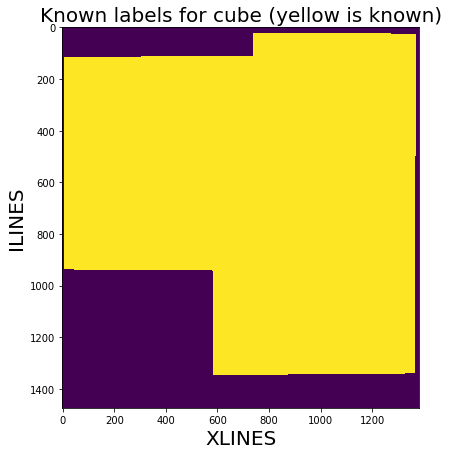

In [7]:
m = np.zeros((geom.ilines_len, geom.xlines_len))
for point in tqdm_notebook(possible_coordinates):
    if point in labels.keys():
        m[point[0] - geom.ilines_offset, point[1] - geom.xlines_offset] += len(labels[point])

fig, ax = plt.subplots(figsize=(12, 7))
ax.imshow(m)
ax.set_title('Known labels for cube (yellow is known)', fontdict={'fontsize': 20})
plt.xlabel('XLINES', fontdict={'fontsize': 20})
plt.ylabel('ILINES', fontdict={'fontsize': 20})
plt.show() 

In [ ]:
path_save = '../../data/Facies/VU_ONGMK/Repaired_new.sgy'
repair(path_data, geom, path_save)